Learn iterator for multiphase elastic problems using PAC-FEANet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
from functools import reduce

from utils import plot
import feanet.pac as pac
from feanet.model import PACFEANet
from feanet.jacobi import JacobiBlock
from data.dataset import ThermalDataSet

Test PAC-FEANet for thermal problems 

In [2]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu') #
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
train = False # True or False
model_name = 'thermal_type2_2phase_33x33_attention'
training_set = ThermalDataSet('data/thermal/thermal_type2_nphase_33x33.h5', device)
model_dir = 'model/learn_iterator/thermal_type2'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

nb_layers = 3
bs = 20
train_dataloader = DataLoader(training_set, batch_size=bs, shuffle=True)
dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, material_train, f_train, u_train = next(iter(train_dataloader))
k = 0 # the index of training data to be shown

In [4]:
n_test = 2**7
test_set = ThermalDataSet('data/thermal/thermal_type2_2phase_129x129_hcontrast.h5', device)

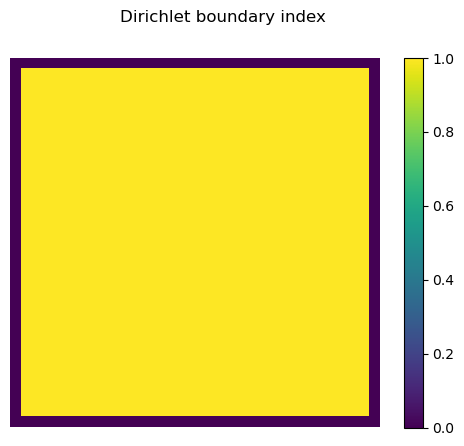

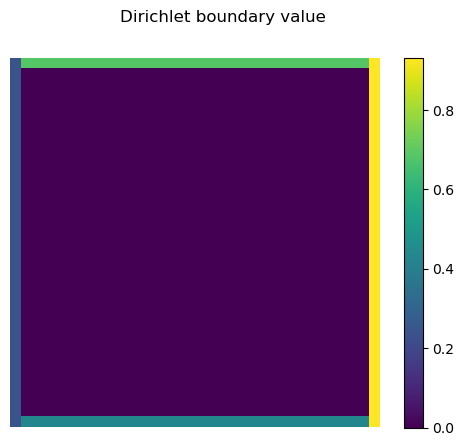

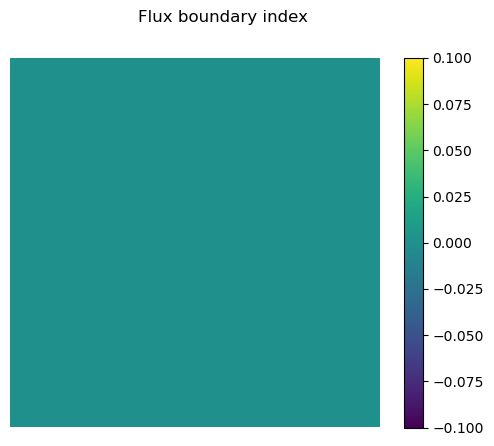

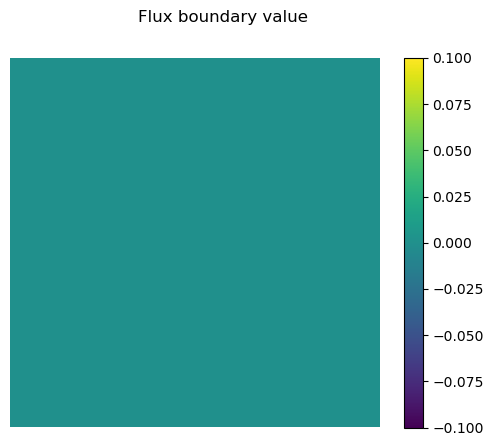

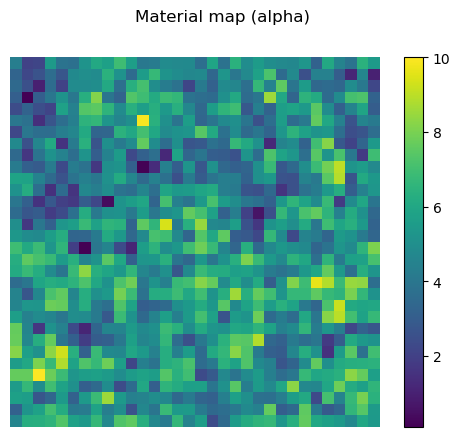

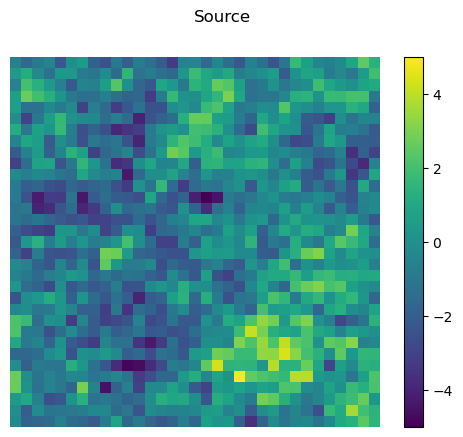

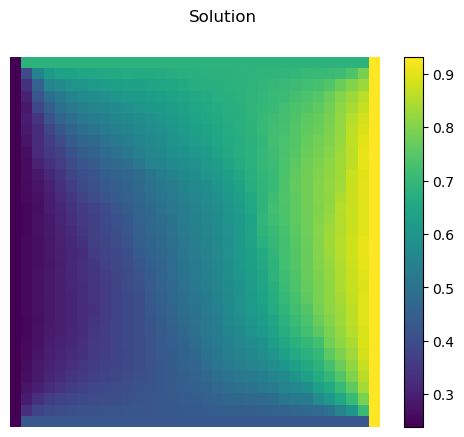

''

In [5]:
plot.plot_thermalfield(dirich_idx_train[k], ftitle='Dirichlet boundary index')

plot.plot_thermalfield(dirich_value_train[k], ftitle='Dirichlet boundary value')
plot.plot_thermalfield(neumann_idx_train[k], ftitle='Flux boundary index')
plot.plot_thermalfield(neumann_value_train[k], ftitle='Flux boundary value')
plot.plot_thermalfield(material_train[k], ftitle='Material map (alpha)')
plot.plot_thermalfield(f_train[k], ftitle='Source')
plot.plot_thermalfield(u_train[k], ftitle='Solution')
''''''

In [6]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    '''
    def __init__(self, size, n_elem, mode, dev):
        self.size = size # actual size of the plate
        self.mode = mode
        self.device = dev
        self.n_elem = n_elem
        self.h = size/n_elem
        self.v = torch.zeros((1, 1, n_elem+1, n_elem+1), requires_grad=False).double()
        self.f = torch.zeros((1, 1, n_elem+1, n_elem+1), requires_grad=False).double()
        self.net = self.InstantiateNetwork()
        self.jac = JacobiBlock(self.net, self.h, self.device, self.mode)

    def IsCoarsest(self):
        return self.n_elem == 2
        
    def InstantiateNetwork(self):
        model = PACFEANet(self.device, self.mode).double()
        model.requires_grad_(False)
        return model.to(self.device)

In [7]:
domain_size = 2
n_elem = 2**5
ku, kf = 1, 1
h = domain_size/n_elem
grid = SingleGrid(domain_size, n_elem=n_elem, mode='thermal', dev=device_predict)

In [8]:
solution_test, f_test, d_test, d_idx_test, t_test, t_idx_test, m_test = (torch.unsqueeze(u_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_train[k], 0).to(device_predict))


0 30.09135218474377
1 16.59984489588716
2 11.75668387315033
3 9.223518588451546
4 7.653249511306401
5 6.5830714040116955
6 5.807964822353949
7 5.221525830454296
8 4.762515119964823
9 4.393150672647024
10 4.088948780572686
11 3.833439350289303
12 3.615199378279696
13 3.4260951698563247
14 3.2601986585563485
15 3.113098221479478
16 2.9814487096977764
17 2.8626706550714247
18 2.7547447579680506
19 2.656068575735929
20 2.565354666214443
21 2.4815569147976926
22 2.403816390308637
23 2.3314209778697856
24 2.2637748944325704
25 2.2003754022305553
26 2.140794837215258
27 2.0846666104905123
28 2.031674212111564
29 1.9815425058013434
30 1.9340307868768398
31 1.888927207815826
32 1.8460442721638841
33 1.8052151684410604
34 1.766290768554341
35 1.729137154941652
36 1.6936335707685912
37 1.6596707104670192
38 1.6271492855454528
39 1.5959788142287774
40 1.566076594067386
41 1.537366824913081
42 1.509779856130911
43 1.483251537009566
44 1.4577226533578869
45 1.4331384364675328
46 1.4094481331638034
4

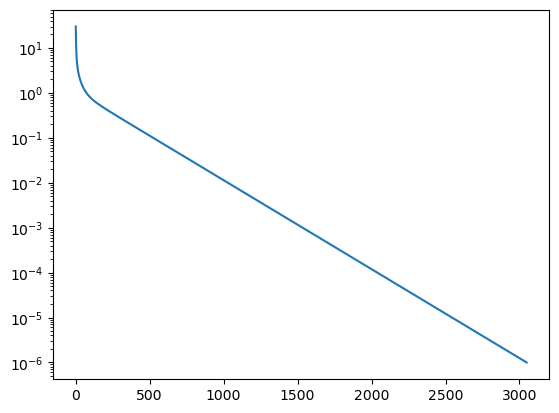

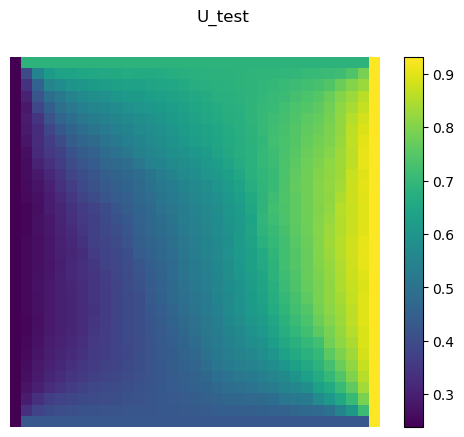

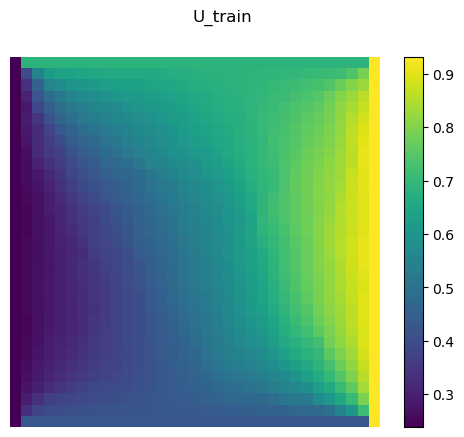

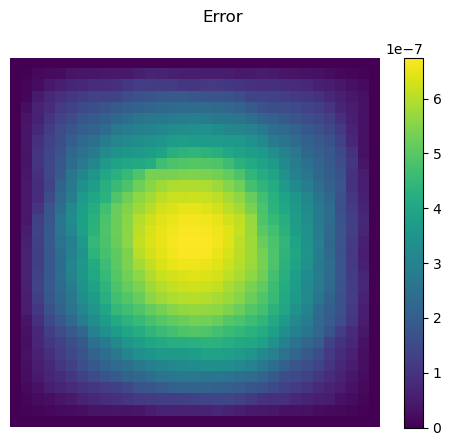

In [9]:
EPS = 1e-6
n_jac = 0
u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
u_test = grid.jac.reset_boundary(u_test, d_test, d_idx_test)
residual = d_idx_test*grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
res = torch.norm(residual).item() 
res_arr = [res]

print(n_jac, res)
while (abs(res) > EPS):
    u_test = grid.jac.jacobi_convolution(u_test, m_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_idx_test)
    residual = d_idx_test*grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item() 
    res_arr.append(res)
    n_jac += 1
    print(n_jac, res)

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

plot.plot_thermalfield(u_test[0], "U_test")
plot.plot_thermalfield(solution_test[0], "U_train")
plot.plot_thermalfield(u_test[0]-solution_test[0], 'Error')

In [10]:
class AttentionHNet(nn.Module):
    def __init__(self, nb_layers=3, mode='thermal'):
        super(AttentionHNet, self).__init__()

        self.mode = mode
        self.k_size = 3
        self.nb_layers = nb_layers
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2
            
        self.attention_map = nn.Sequential(
            nn.Conv2d(self.km, 1, kernel_size=2, padding=1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.Conv2d(1, self.k_size*self.k_size, kernel_size=self.k_size//2),
            nn.BatchNorm2d(self.k_size*self.k_size)
            )
        self.nonlinear = nn.Tanh()

        self.pac_smoother = nn.ModuleList([pac.PacConv2d(self.ku, self.ku, 3, padding=1, bias=False)
                                         for _ in range(nb_layers)])

    def forward(self, x, m, dirich_idx):
        '''
        x: error between Jacobi solution and initial guess 
        smoother: learned smoother (Psi) network '''

        bs0, ku0, h0, w0 = x.size()
        
        # get the material kernels
        attention_kernels = self.attention_map(m)
        nonlinear_kernels = self.nonlinear(attention_kernels).view(bs0, 1, self.k_size, self.k_size, h0, w0) # shape (bs, 1, 3, 3, h, w)

        new_x = x.clone()
        for i in range(self.nb_layers):
            new_x = self.pac_smoother[i](new_x, None, nonlinear_kernels)
            new_x = new_x*dirich_idx # error at dirichlet boundary is zero

        return new_x.clone()

In [11]:
class PsiIterator(nn.Module):
    def __init__(self, 
                 dev,
                 size=2, 
                 att_net=None,
                 grid=None,
                 n=2**5,
                 nb_layers=3,
                 batch_size=1,
                 max_epochs=1000,
                 mode='thermal',
                 model_dir=model_dir):
        super(PsiIterator, self).__init__()
        self.size = size
        self.device = dev
        self.n = n
        self.h = size/n
        self.mode = mode
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.loss = nn.MSELoss()
        
        if(grid is None):
            self.grid = SingleGrid(size, n, mode=mode, dev=self.device)
        else:
            self.grid = grid

        if(att_net is None):
            self.att_net = AttentionHNet(nb_layers=nb_layers, mode=self.mode).to(self.device).double()
        else:
            self.att_net = att_net.to(self.device).double()

        self.optimizer = torch.optim.Adadelta(self.att_net.parameters())
        self.model_dir=model_dir

    def PsiRelax(self, v, m, d, d_idx, term_KU=None, term_F=None, h=None, f=None, t=None, t_idx=None, num_sweeps_down=1):
        '''
        Perform a fixed number of Psi iteration
        '''
        u = v.clone()
        for _ in range(num_sweeps_down):
            jac_it = self.grid.jac.jacobi_convolution(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx)
            u = jac_it + self.att_net(jac_it-u, m, d_idx) 
        return u.clone()

    def RandomSampling(self, x):
        u = torch.randn_like(x).double().to(self.device)
        return u

    def TrainSingleEpoch(self, train_dataloader):
        running_loss = 0.
        for i, data in enumerate(train_dataloader):
            self.att_net.train()
            dirich_idx_train, dirich_value_train, traction_idx_train, traction_value_train, material_train, f_train, u_train = data
        
            #print(u_train.shape)
            self.optimizer.zero_grad() # zero the gradients for every batch
            k = 1 #random.randint(1,20)

            uu = self.RandomSampling(f_train)
            u_out = self.PsiRelax(uu, material_train, dirich_value_train, dirich_idx_train, None, None, self.h, f_train, traction_value_train, traction_idx_train, k)
            loss_i = self.loss(u_out, u_train)
            loss_i.backward()
            self.optimizer.step()
        
            running_loss += loss_i.item()
    
        last_loss = running_loss/(i+1)
        return last_loss
    
    def Train(self, training_set):
        train_dataloader = DataLoader(training_set, batch_size=self.batch_size, shuffle=True)
        loss_train = torch.zeros((self.max_epochs, 1))
        avg_loss = self.TrainSingleEpoch(train_dataloader)
        loss_train[0] = avg_loss
        print('Step-0 loss:', avg_loss)

        for epoch in range(1, self.max_epochs):
            avg_loss = self.TrainSingleEpoch(train_dataloader)
            if(epoch % 50 == 0):
                print('Step-'+str(epoch)+' loss:', avg_loss)

            # save the model's state
            mpath = os.path.join(self.model_dir,model_name+'.pth')
            torch.save(self.att_net.state_dict(), mpath)
            loss_train[epoch] = avg_loss
        return loss_train

In [12]:
max_epochs = 2000
att_net = AttentionHNet(nb_layers=nb_layers, mode='thermal').to(device_predict)
my_iterator = PsiIterator(device, batch_size=bs, mode='thermal', att_net=att_net, nb_layers=nb_layers, max_epochs=max_epochs)

loss_train = torch.zeros((max_epochs, 1))
if(train):
    loss_train = my_iterator.Train(training_set)

    plt.plot(loss_train)
    plt.ylabel('loss')
    plt.yscale('log')
    plt.xlabel('epoch')
    print("Average loss: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

    # save the list
    torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))


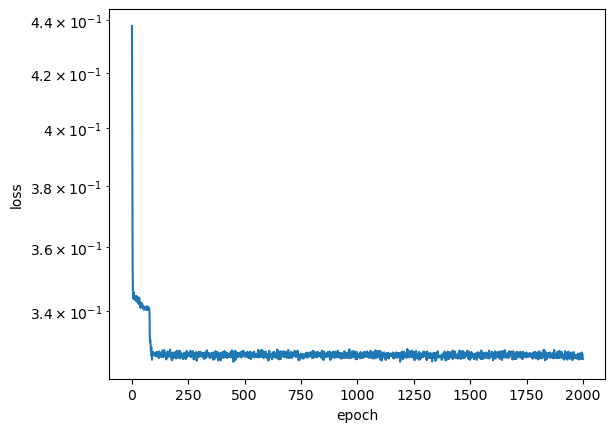

In [13]:
# import the learned model and loss train
new_iterator = PsiIterator(device_predict, att_net=att_net, nb_layers=nb_layers, grid=grid, batch_size=1)
new_iterator.att_net.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))

my_loss = torch.load(os.path.join(model_dir,model_name+'.pt'))
plt.plot(my_loss)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.savefig('results/smoother_loss.jpg', dpi=500, bbox_inches='tight')

0 30.09135218474377
1 11.099349643340824
2 5.734148242205132
3 3.8058818383849373
4 2.98712682869191
5 2.538000628433634
6 2.2319713501140606
7 1.9968027591615216
8 1.8058881423565973
9 1.646701986398306
10 1.5119452549435701
11 1.3966984273745462
12 1.297356981283121
13 1.2111488010496896
14 1.1358765492698653
15 1.0697653237731795
16 1.0113627433986554
17 0.959470325861961
18 0.9130933139491695
19 0.8714028764974178
20 0.8337065988929024
21 0.7994249805763814
22 0.7680723677764861
23 0.7392413107317753
24 0.7125896223494901
25 0.6878296189770775
26 0.6647191486770859
27 0.6430540995587851
28 0.6226621412690366
29 0.6033974975785688
30 0.585136582399553
31 0.5677743589459519
32 0.5512213041587504
33 0.5354008791823036
34 0.5202474224080263
35 0.5057043949220392
36 0.49172291949516406
37 0.47826056383306503
38 0.4652803269078876
39 0.45274979402784876
40 0.44064043205010084
41 0.42892700096279385
42 0.41758706209371
43 0.4066005665662436
44 0.3959495104233519
45 0.38561764516696334
46 

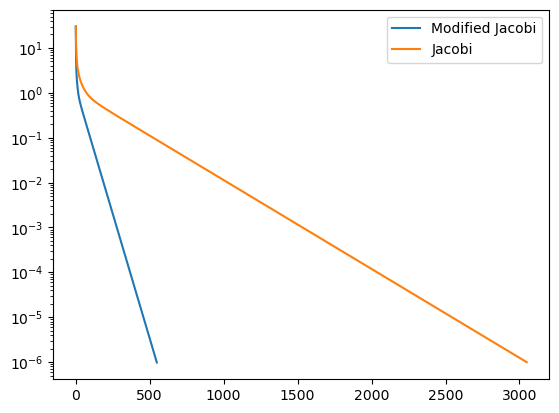

In [14]:
EPS = 1e-6
att_net.eval()
with torch.no_grad():
    n_new = 0
    u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
    u_test = new_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
    residual = d_idx_test*new_iterator.grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item() # fix top, apply traction force at bottom boundary
    res_arr_new = [res]
    print(n_new, res)
    while (abs(res) > EPS and n_new < 5000):
        u_test = new_iterator.PsiRelax(u_test, m_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*new_iterator.grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_new.append(res)
        n_new += 1
        print(n_new, res)

print("Solution converges after", n_new, "iterations ")
plt.plot(res_arr_new, label='Modified Jacobi')
plt.plot(res_arr, label='Jacobi')
plt.yscale('log')
plt.legend()
plt.show()

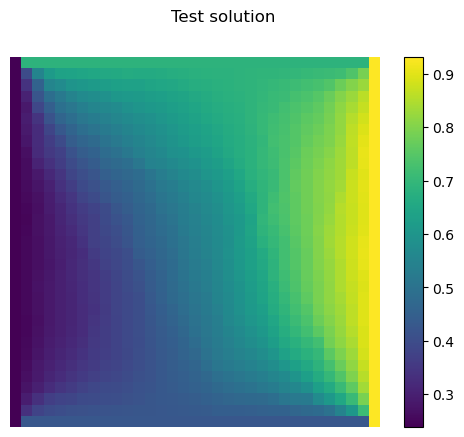

In [15]:
plot.plot_thermalfield(u_test[0], 'Test solution')

In [16]:
# test multigrid performance

class RestrictionNet(nn.Module):
    '''Given an initial kernel, inter-grid communication'''
    def __init__(self, chs):
        super(RestrictionNet, self).__init__()
        self.chs = chs
        self.net = nn.Conv2d(in_channels=chs, out_channels=chs, kernel_size=3, stride=2, bias=False, groups=chs) # restriction
        self.edge_net = nn.Conv1d(in_channels=chs, out_channels=chs, kernel_size=3, stride=2, bias=False, groups=chs) # restrict the edge boundaries
        for i in range(self.chs):
            self.net.state_dict()['weight'][i][0] = torch.asarray([[1., 2., 1.],
                                                                   [2., 4., 2.],
                                                                   [1., 2., 1.]]) / 4.0
            self.edge_net.state_dict()['weight'][i][0] = torch.asarray([1., 2., 1.]) / 2.0
    
    def forward(self, x):
        internal = self.net(x[:, :, 1:-1, 1:-1].clone())
        x_C = F.pad(internal,(1,1,1,1),"constant",0) # coarse grid field
        x_C[:, :,  0, 1:-1] = self.edge_net(x[:, :, 0, 1:-1].clone())
        x_C[:, :, -1, 1:-1] = self.edge_net(x[:, :, -1, 1:-1].clone())
        x_C[:, :, 1:-1,  0] = self.edge_net(x[:, :, 1:-1, 0].clone())
        x_C[:, :, 1:-1, -1] = self.edge_net(x[:, :, 1:-1, -1].clone())
        x_C[:,:,0,0] = x[:,:,0,0]
        x_C[:,:,0,-1] = x[:,:,0,-1]
        x_C[:,:,-1,0] = x[:,:,-1,0]
        x_C[:,:,-1,-1] = x[:,:,-1,-1]
        return x_C


class ProlongationNet(nn.Module):
    '''Given an initial P kernel'''
    def __init__(self, chs):
        super(ProlongationNet, self).__init__()
        self.chs = chs
        self.net = nn.ConvTranspose2d(in_channels=chs,out_channels=chs, kernel_size=3, stride=2, padding=1, bias=False, groups=chs) # interpolation
        for i in range(self.chs):
            self.net.state_dict()['weight'][i][0] = torch.asarray([[1., 2., 1.],
                                                                   [2., 4., 2.],
                                                                   [1., 2., 1.]]) / 4.0
            
    def forward(self, x): 
        return self.net(x)

In [17]:
class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n, attnet, device, nb_layers, mode='thermal', iterator = 'jac'):
        super(MultiGrid, self).__init__()

        # Problem parameters
        self.device = device
        self.size = 2.
        self.nb_layers = nb_layers
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.attnet = attnet
        self.iterator = iterator
        
        self.mode = mode
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2

        self.iterators = self.IteratorDict() # dictionary of iterators

        # Inter-grid communication network models
        self.conv = RestrictionNet(self.kf).double().to(device)
        self.deconv = ProlongationNet(self.ku).double().to(device)
        
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)
        self.attnet.requires_grad_(False)

        self.mse_loss = nn.MSELoss()
    
    def IteratorDict(self):
        iterators = {}
        for i in range(self.L):
            prob_size = int(self.n/(2.**i))
            iterators[i] = PsiIterator(self.device, size=self.size, att_net=self.attnet, n=prob_size, nb_layers=self.nb_layers, mode=self.mode)
        return iterators
            
    def ProblemDictArray(self, u0, f, t, t_idx, d, d_idx, m):
        '''
        Array of dictionary that stores the problem hierarchy
        There are two approaches that can be used to create grid hierarchy:
        1) mat = F.conv2d(mat.reshape((1,1,n,n)), torch.ones((1,1,1,1)), stride=2)
        2) mat = F.max_pool2d(mat.reshape((1,1,n,n)), kernel_size=2, stride=2)
        '''
        kernel_u = torch.ones((self.ku,1,1,1)).double().to(self.device)
        kernel_f = torch.ones((self.kf,1,1,1)).double().to(self.device)
        kernel_m = torch.ones((self.km,1,1,1)).double().to(self.device)
        prob = {}
        prob['h'] = self.size/self.n
        prob['u0'] = self.iterators[0].grid.jac.reset_boundary(u0, d, d_idx)
        prob['f'], prob['t'], prob['t_idx'] = f.clone(), t.clone(), t_idx.clone()
        prob['d'], prob['d_idx'], prob['m'] = d.clone(), d_idx.clone(), m.clone()
        self.p_arr = [prob]
        for i in range(self.L-1):
            prob = {}
            prob['h'] = self.size/self.n*(2.**(i+1))
            prob['u0'] = F.conv2d(self.p_arr[i]['u0'], kernel_u, stride=2, groups=self.ku)
            prob['f'] = F.conv2d(self.p_arr[i]['f'], kernel_f, stride=2, groups=self.kf)
            prob['t'] = F.conv2d(self.p_arr[i]['t'], kernel_f, stride=2, groups=self.kf)
            prob['t_idx'] = F.conv2d(self.p_arr[i]['t_idx'], kernel_f, stride=2, groups=self.kf)
            prob['d'] = 0.*F.conv2d(self.p_arr[i]['d'], kernel_u, stride=2, groups=self.ku) # Dirichlet boundary is homogeneous at coarse grids
            prob['d_idx'] = F.conv2d(self.p_arr[i]['d_idx'], kernel_u, stride=2, groups=self.ku)
            prob['m'] = F.conv2d(self.p_arr[i]['m'], kernel_m, stride=2, groups=self.km)
            #prob['m'] = F.max_pool2d(self.p_arr[i]['m'], kernel_size=2, stride=2)
            self.p_arr.append(prob)

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        '''
        rFC = self.conv(rF.clone())
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def forward(self, k):
        U = self.p_arr[0]['u0'].clone()
        for i in range(k-1):
            U = self.Step(U).detach()
        self.last_v = U.clone()
        return self.Step(U)

    def Relax(self, iter, u, m, d, d_idx, term_KU=None, term_F=None, h=None, f=None, t=None, t_idx=None, n_iter=1):
        if(self.iterator == 'jac'):
            return iter.grid.jac.jacobi_convolution(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx)
        else:
            return iter.PsiRelax(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx, n_iter)

    def Step(self, v):
        '''Input v is the initial solution on the finest grid'''
        n_relax = 1 # number of relaxations        
        self.iterators[0].grid.v = self.Relax(self.iterators[0], v, self.p_arr[0]['m'], 
                                              self.p_arr[0]['d'], self.p_arr[0]['d_idx'],
                                              None, None,
                                              self.p_arr[0]['h'], self.p_arr[0]['f'], 
                                              self.p_arr[0]['t'], self.p_arr[0]['t_idx'], 
                                              n_relax)
        self.iterators[0].grid.f = self.iterators[0].grid.net.term_F

        for j in range(0, self.L-1):
            # calculate fine grid residual
            rF = self.iterators[j].grid.net(u=self.iterators[j].grid.v, material_input=self.p_arr[j]['m'],
                                            term_F=self.iterators[j].grid.f)
            self.iterators[j+1].grid.f = self.Restrict(rF)
            self.iterators[j+1].grid.v = torch.zeros_like(self.iterators[j+1].grid.f) 
            self.iterators[j+1].grid.v = self.Relax(self.iterators[j+1], self.iterators[j+1].grid.v, 
                                              self.p_arr[j+1]['m'], 
                                              self.p_arr[j+1]['d'], self.p_arr[j+1]['d_idx'],
                                              term_F=self.iterators[j+1].grid.f, 
                                              n_iter=n_relax)

        self.iterators[self.L-1].grid.v = self.Relax(self.iterators[self.L-1], self.iterators[self.L-1].grid.v, 
                                              self.p_arr[self.L-1]['m'], 
                                              self.p_arr[self.L-1]['d'], self.p_arr[self.L-1]['d_idx'],
                                              term_F=self.iterators[self.L-1].grid.f, 
                                              n_iter=n_relax)

        for j in range(self.L-2,-1,-1):
            eF_delta = self.Interpolate(self.iterators[j+1].grid.v)
            self.iterators[j].grid.v = self.iterators[j].grid.v + eF_delta
            self.iterators[j].grid.v = self.Relax(self.iterators[j], self.iterators[j].grid.v, 
                                              self.p_arr[j]['m'], 
                                              self.p_arr[j]['d'], self.p_arr[j]['d_idx'],
                                              term_F=self.iterators[j].grid.f, 
                                              n_iter=n_relax)

            # zero out the previous level solution
            self.iterators[j+1].grid.v *= 0. 

        return self.iterators[0].grid.v 

In [18]:
bs = 5
train_dataloader = DataLoader(test_set, batch_size=bs, shuffle=True)
dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, material_train, f_train, u_train = next(iter(train_dataloader))
k=2
solution_test, f_test, d_test, d_idx_test, t_test, t_idx_test, m_test = (torch.unsqueeze(u_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_train[k], 0).to(device_predict))


In [19]:
att_net.eval()
with torch.no_grad():
    n = n_test
    h = 2./n
    n_mg_jac = 0
    mg_jac = MultiGrid(n=n, attnet=new_iterator.att_net, nb_layers=nb_layers, device=device, iterator='jac') # create a multigrid model
    u_mg_jac = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    mg_jac.ProblemDictArray(u_mg_jac,f_test,t_test,t_idx_test,d_test,d_idx_test,m_test)
    u_mg_jac = mg_jac.p_arr[0]['u0']
    residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgjac = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        #u_mg = mg_jac.Relax(mg_jac.iterators[0], u_mg, m_test, d_test,d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_mgjac.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')


0 2.6941575720052318
1 0.6305674984447701
2 0.22812627834711585
3 0.2234705157048458
4 0.2986777805000061
5 0.44101833042977634
6 0.6892412600534156
7 1.0922733617816678
8 1.7591102728034198
9 2.8465627962183278
10 4.657340394577444
11 7.727070841404458
12 13.152835539999826
13 23.269659602803657
14 43.40598872846713
15 85.88531935866055
16 179.28700848460863
17 389.51771708132077
18 868.3999362254158
19 1965.7425341995277
20 4488.142204485837
21 10296.399452523166
22 23684.90290652877
23 54566.69762578177
24 125828.72652953072
25 290318.15762424155
26 670072.8201723443
27 1546928.0717652473
28 3571788.303587831
29 8247982.855927353
30 19047691.951930594
31 43990624.952742405
32 101600197.88359529
33 234661064.30345258
34 541996278.4904034
35 1251866450.002755
36 2891508095.249431
37 6678736239.189508
38 15426475942.367666
39 35632069203.453926
40 82303205404.2299
41 190104974948.21164
42 439107619134.60974
43 1014259357989.7611
44 2342758314851.724
45 5411357899836.531
46 124992874385

In [20]:
att_net.eval()
with torch.no_grad():
    h = 2./n
    n_mg_psi = 0
    mg_jac = MultiGrid(n=n, attnet=new_iterator.att_net, nb_layers=nb_layers, device=device, iterator='psi') # create a multigrid model
    u_mg_psi = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    mg_jac.ProblemDictArray(u_mg_psi,f_test,t_test,t_idx_test,d_test,d_idx_test,m_test)
    u_mg_psi = mg_jac.p_arr[0]['u0']
    residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_psi, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgpsi = [res]
    print(n_mg_psi, res)

    start = time.time()
    while (abs(res) > EPS and n_mg_psi < 1000):
        u_mg_psi = mg_jac.Step(u_mg_psi)
        #u_mg = mg_jac.Relax(mg_jac.iterators[0], u_mg, m_test, d_test,d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_psi, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_mgpsi.append(res)
        n_mg_psi += 1
        print(n_mg_psi, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_psi, "Psi-Jacobi multigrid iterations in", end-start, 'seconds.')


0 2.6941575720052318
1 0.6329832792246026
2 0.14748776850427434
3 0.08366952038922387
4 0.06313753711015328
5 0.05184164997050494
6 0.04420711774609158
7 0.038163743746080885
8 0.03329732362444833
9 0.029104580874898714
10 0.025497916752037535
11 0.022328183722013
12 0.01955081294317124
13 0.017104883215695026
14 0.014956223829494594
15 0.013068119815176278
16 0.011411959348757689
17 0.009960332796131533
18 0.008689536852589438
19 0.007577914648968742
20 0.006606323764082258
21 0.00575764115772052
22 0.0050167279838842236
23 0.004370185861038804
24 0.0038062123257449907
25 0.003314422717576877
26 0.0028856998921705248
27 0.002512049216827891
28 0.0021864686109590403
29 0.0019028308394646778
30 0.0016557779888547821
31 0.0014406277899497216
32 0.00125329031660602
33 0.0010901946094394664
34 0.0009482238642461998
35 0.0008246585508793711
36 0.0007171263931036374
37 0.000623558556471681
38 0.0005421512269862584
39 0.00047133199918965307
40 0.00040973045132368884
41 0.00035615242495895354


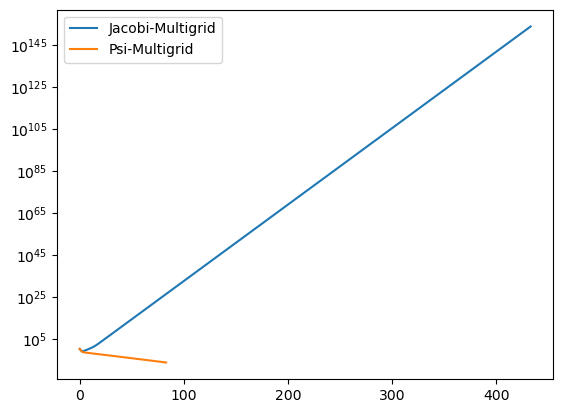

In [21]:
plt.plot(res_arr_mgjac, label='Jacobi-Multigrid')
plt.plot(res_arr_mgpsi, label='Psi-Multigrid')
plt.yscale('log')
plt.legend()
plt.show()

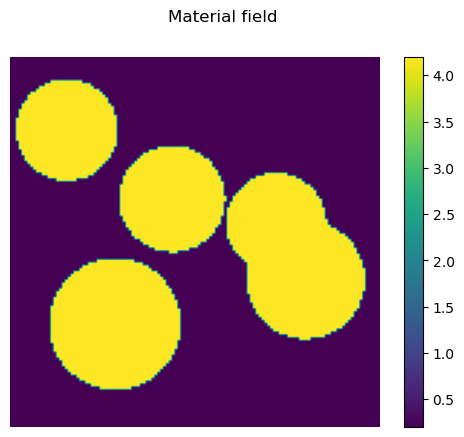

In [22]:
plot.plot_thermalfield(m_test.reshape(n, n), 'Material field')

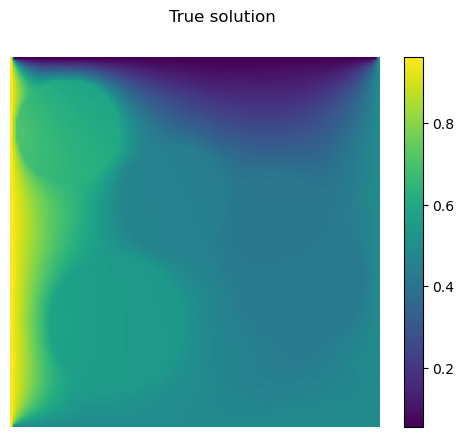

In [23]:
plot.plot_thermalfield((solution_test).reshape(n+1,n+1), 'True solution')

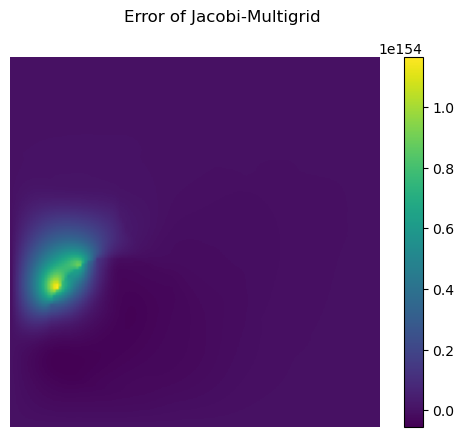

In [24]:
plot.plot_thermalfield((u_mg_jac-solution_test).reshape(n+1,n+1), 'Error of Jacobi-Multigrid')

In [25]:
u_mg_jac-solution_test

tensor([[[[  0.0000e+00,   0.0000e+00,   0.0000e+00,  ...,   0.0000e+00,
             0.0000e+00,   0.0000e+00],
          [  0.0000e+00, -9.1039e+148, -1.8127e+149,  ..., -6.8136e+148,
           -3.4117e+148,   0.0000e+00],
          [  0.0000e+00, -1.7976e+149, -3.5804e+149,  ..., -1.3617e+149,
           -6.8182e+148,   0.0000e+00],
          ...,
          [  0.0000e+00, -4.1840e+150, -8.3449e+150,  ..., -3.9545e+149,
           -1.9812e+149,   0.0000e+00],
          [  0.0000e+00, -2.0938e+150, -4.1758e+150,  ..., -1.9815e+149,
           -9.9273e+148,   0.0000e+00],
          [  0.0000e+00,   0.0000e+00,   0.0000e+00,  ...,   0.0000e+00,
             0.0000e+00,   0.0000e+00]]]], device='cuda:0',
       dtype=torch.float64)

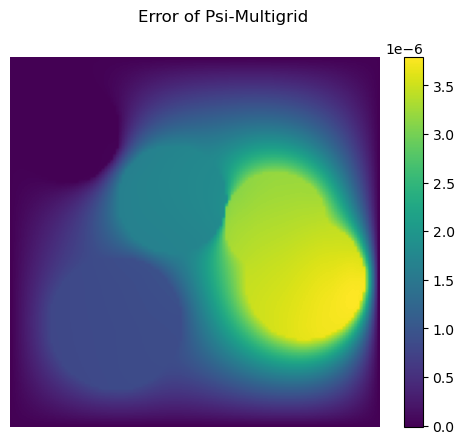

In [26]:
plot.plot_thermalfield((u_mg_psi.detach()-solution_test).reshape(n+1,n+1), 'Error of Psi-Multigrid')

In [27]:
u_mg_psi.detach()-solution_test

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -9.5456e-11, -1.9045e-10,  ...,  4.2772e-09,
            2.1407e-09,  0.0000e+00],
          [ 0.0000e+00, -1.8899e-10, -3.7422e-10,  ...,  8.5597e-09,
            4.2840e-09,  0.0000e+00],
          ...,
          [ 0.0000e+00,  4.0285e-09,  8.0607e-09,  ...,  1.7960e-08,
            8.9935e-09,  0.0000e+00],
          [ 0.0000e+00,  2.0143e-09,  4.0295e-09,  ...,  8.9701e-09,
            4.4917e-09,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]]], device='cuda:0', dtype=torch.float64)